## Homework 4: Mean Shift

**Release date:** Apr 14th 2025

**Due date:** May 2nd 2025

The goal of the assignment is to implement the mean shift algorithm and use it for image segmentation. You should return the completed notebook, including answers and illustrations. 


**Part 1: mean shift on synthetic data**

* Generate a synthetic dataset of 100 2D points, containing 60 points sampled from a Gaussian distribution of unit covariance centered in (0,0) and 40 points sampled from a Gaussian with unit covariance centered in (4,4). Visualize your data.
* Implement a function that computes $G(x) = g(\|x\|^2/h^2)$ where $x \in \mathbb R^d$, $h$ is a bandwidth parameter and $g$ is the negative derivative of the Gaussian kernel or of the Epanechnikov kernel (see eq. 5.36 in Szeliski).  Plot $G(x)$ for $d=1$.
* Implement a function `MS_step` that takes as input a starting point `x`, a set of data points `data`, and a bandwidth `h` and returns the updated position of the point `x` after one step of the mean-shift algorithm.
* Implement the function `MS_point` which iterates `MS_step` until convergence (i.e., when the estimate changes by less than a small constant). Test it on your synthetic data and visualize the results.
* Implement the full mean shift algorithm by iterating `MS_point` on all the points, and merging modes for which distance is less than some constant. It should return a list of the modes and a label (corresponding to a mode) for each point. Visualize your results.
* Modify the previous code by allowing for a "bandwidth vector" $h \in \mathbb R^d$ that defines a different scale for each dimension of the input (this is because for segmentation we will use a different bandwidth for space and color). Note that you should also modify the convergence and merging conditions to consider this non-isotropic scaling.
* Experiment with your code by changing the data distribution, the kernel, and and bandwidth vector.

**Part 2: mean shift for image segmentation**

* For image segmentation, we will use the "Lab" color space because it approximates the way humans perceive color better than RGB. Load the image `veggies_small.jpg`, and convert it to the Lab colorspace using the command `rgb2lab`. What is the range of the colorvalues in Lab? 
* Convert the (N,M,3) image into an (NM,5) matrix incuding color and position information for each point (tip: use the `np.meshgrid` function). What do you think might be a good choice for a bandwidth vector $h$?
* Use your mean shift code from the previous section to compute a meaningful segmentation of the image. Visualize the results as an image by replacing the color values of the pixels associated with each mode by the color of the mode. You can also try our algorithm on other (small) images.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


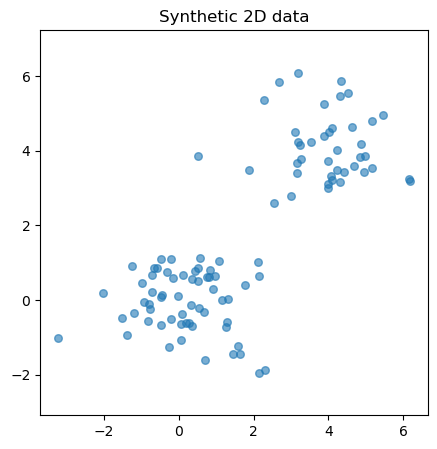

In [22]:
# Parameters
n1, n2 = 60, 40
mean1, mean2 = np.array([0,0]), np.array([4,4])
cov = np.eye(2)

# Sample points
data1 = np.random.multivariate_normal(mean1, cov, size=n1)
data2 = np.random.multivariate_normal(mean2, cov, size=n2)
data = np.vstack([data1, data2])

# Plot
plt.figure(figsize=(5,5))
plt.scatter(data[:,0], data[:,1], s=30, alpha=0.6)
plt.title("Synthetic 2D data")
plt.axis('equal')
plt.show()


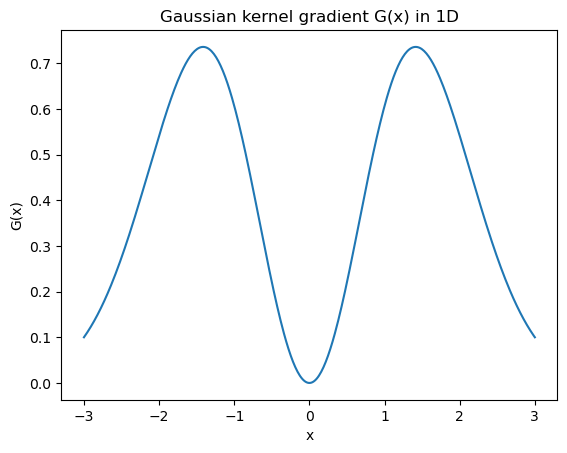

In [23]:
def G(x_sq_norm, h, kernel='gaussian'):
    t = x_sq_norm / (h**2)
    if kernel == 'gaussian':
        return t * np.exp(-0.5 * t)
    elif kernel == 'epanechnikov':
        return np.where(t <= 1, 1.0, 0.0)
    else:
        raise ValueError("Unknown kernel")

# 1D plot
h1 = 1.0
xs = np.linspace(-3, 3, 400)
ys = G(xs**2, h1, kernel='gaussian')
plt.plot(xs, ys)
plt.title("Gaussian kernel gradient G(x) in 1D")
plt.xlabel("x"); plt.ylabel("G(x)")
plt.show()


In [24]:
def MS_step(x, data, h, kernel='gaussian'):
    # If h is scalar, turn into vector of same dimension
    x = x.reshape(1, -1)
    d = data - x           # shape (n, d)
    if np.isscalar(h):
        h_vec = np.full(data.shape[1], h)
    else:
        h_vec = np.array(h)
    # Compute squared, scaled distances per dimension
    scaled = (d / h_vec)**2
    sq_norms = scaled.sum(axis=1)          # shape (n,)
    weights = G(sq_norms, 1.0, kernel)     # treat h scaling in sq_norms
    # Weighted mean shift
    return (weights[:,None] * data).sum(axis=0) / weights.sum()


In [25]:
def MS_point(x0, data, h, tol=1e-3, max_iter=100, kernel='gaussian'):
    x = x0.copy()
    for _ in range(max_iter):
        x_new = MS_step(x, data, h, kernel)
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
    return x

# Test on a random start
print(MS_point(np.array([2.0, 1.0]), data, h=1.0))


[0.16422155 0.02690159]


In [26]:
def mean_shift(data, h, merge_tol=1e-1, kernel='gaussian'):
    modes = []
    labels = np.zeros(len(data), dtype=int)
    for i, x0 in enumerate(data):
        mode = MS_point(x0, data, h, kernel=kernel)
        # check if close to existing mode
        found = False
        for j, m in enumerate(modes):
            if np.linalg.norm(mode - m) < merge_tol:
                labels[i] = j
                found = True
                break
        if not found:
            labels[i] = len(modes)
            modes.append(mode)
    return np.array(modes), labels

modes, labels = mean_shift(data, h=1.0)


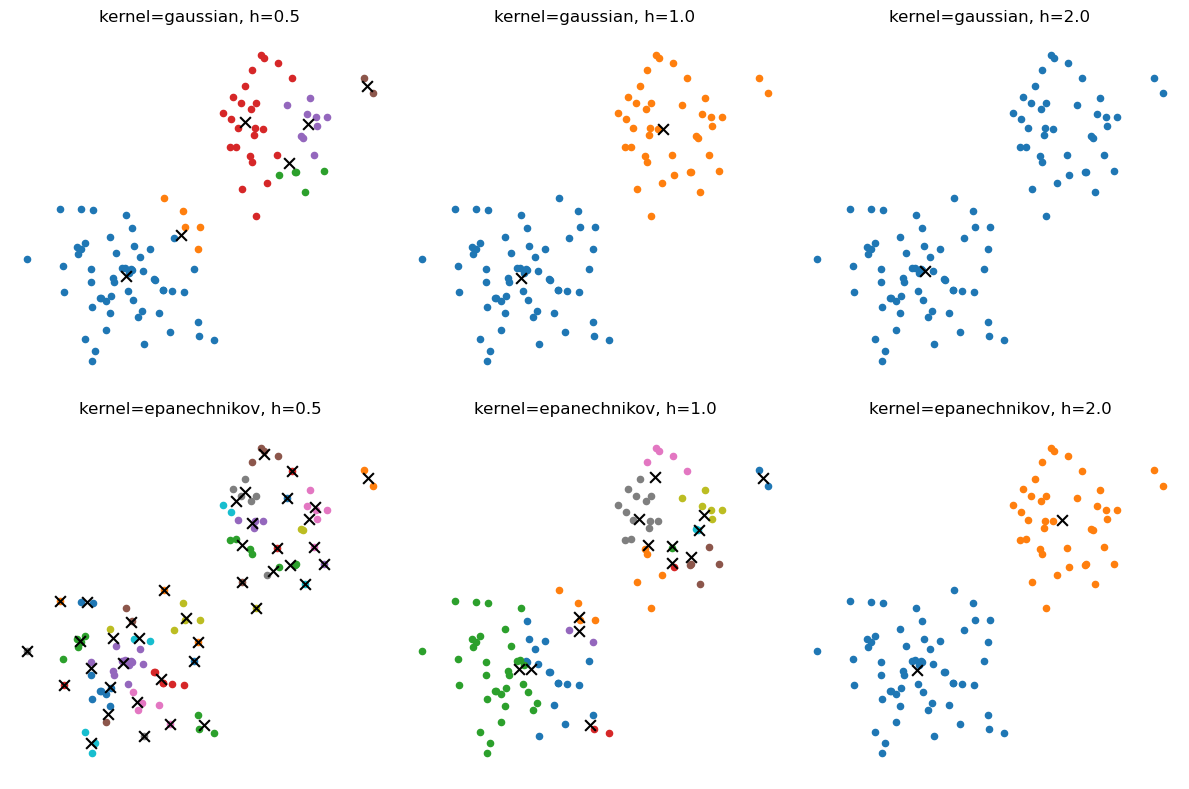

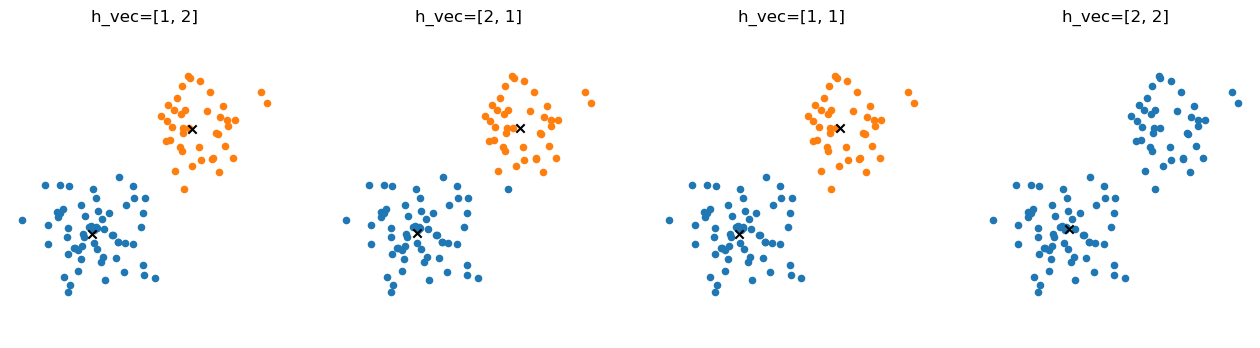

In [43]:

# %%
fig, axes = plt.subplots(2,3, figsize=(12,8))
h_values = [0.5,1.0,2.0]
kernels = ['gaussian','epanechnikov']
for i,kern in enumerate(kernels):
    for j,h in enumerate(h_values):
        ax = axes[i,j]
        modes_j, labels_j = mean_shift(data, h, merge_tol=0.3, kernel=kern)
        for lbl in np.unique(labels_j):
            pts = data[labels_j==lbl]
            ax.scatter(pts[:,0], pts[:,1], s=20)
        ax.scatter(modes_j[:,0], modes_j[:,1], c='k', s=60, marker='x')
        ax.set_title(f"kernel={kern}, h={h}")
        ax.axis('equal'); ax.axis('off')
plt.tight_layout(); plt.show()

# %% [markdown]
# ### Experiment 1.2: Vary anisotropic bandwidth vectors
# Try h_vec in {(1,2), (2,1), (1,1), (2,2)} with Gaussian kernel.

# %%
h_vecs = [[1,2],[2,1],[1,1],[2,2]]
fig, axes = plt.subplots(1,4,figsize=(16,4))
for ax, hv in zip(axes,h_vecs):
    m_v, l_v = mean_shift(data, hv, merge_tol=0.5, kernel='gaussian')
    for lbl in np.unique(l_v):
        ax.scatter(data[l_v==lbl,0], data[l_v==lbl,1], s=20)
    ax.scatter(m_v[:,0], m_v[:,1], c='k', marker='x')
    ax.set_title(f"h_vec={hv}"); ax.axis('equal'); ax.axis('off')
plt.show()

# Part 1

In Part 1 we implement **mean-shift** from scratch on synthetic 2D data. Below is the theoretical foundation.

---

## 1. Problem Setup

We have a dataset of points  
$x_i \in \mathbb{R}^2$, $i=1,\dots,n$,  
where in our assignment $n=100$, with  
- 60 points sampled from $\mathcal{N}\bigl((0,0),I\bigr)$  
- 40 points sampled from $\mathcal{N}\bigl((4,4),I\bigr)$

Our goal is to **discover** the high-density “clusters” (modes) in this data without pre-specifying the number of clusters.

---

## 2. Kernel Density Estimation (KDE)

We estimate the smooth density $\hat f(x)$ by summing “little hills” (kernels) at each data point:

$\displaystyle
\hat f(x)
= \frac{1}{n\,h^2}
\sum_{i=1}^n
K\!\bigl(\tfrac{\|x - x_i\|^2}{h^2}\bigr)
$

- $K(t)$ is a **kernel** function (e.g.\ Gaussian or Epanechnikov).  
- $h>0$ is the **bandwidth**, controlling the width of each hill.

---

## 3. Mean-Shift Vector

Modes (local maxima) of $\hat f$ occur where its gradient vanishes. One can show:

$\displaystyle
\nabla \hat f(x)
\;\propto\;
\sum_{i=1}^n
(x_i - x)\;g\!\bigl(\|\tfrac{x - x_i}{h}\|^2\bigr),
\quad
g(t) = -K'(t).
$

Define the **mean-shift update** as the weighted average:

$x_{\text{new}} = \frac{\sum_{i=1}^n x_i\,g\!\bigl(\|(x - x_i)/h\|^2\bigr)}{\sum_{i=1}^n g\!\bigl(\|(x - x_i)/h\|^2\bigr)}$.


This moves $x$ “uphill” toward a nearby mode of $\hat f$.

---

## 4. Common Kernels

- **Gaussian**  
  $K(t) = \exp(-\tfrac12 t)$  
  $\longrightarrow\;g(t) = -K'(t) = \exp(-\tfrac12 t)$

- **Epanechnikov**  
  $K(t) = \max\{1 - t,\,0\}$  
  $\longrightarrow\;g(t) = \mathbf{1}_{t \le 1}$

---

## 5. Algorithmic Steps

1. **MS_step**  
   - Input: current $x$, dataset $\{x_i\}$, bandwidth $h$, kernel choice.  
   - Compute scaled squared distances $t_i = \|x - x_i\|^2/h^2$.  
   - Compute weights $w_i = g(t_i)$.  
   - Return weighted average $\sum_i w_i\,x_i \;/\; \sum_i w_i$.

2. **MS_point**  
   - Iterate MS_step until $\|x_{\text{new}} - x\| < \text{tol}$ or max iterations.  
   - Output: converged **mode** $\mu$.

3. **Full Clustering**  
   - For each data point $x_i$, run MS_point → $\mu_i$.  
   - **Merge** modes $\mu_i,\mu_j$ if $\|\mu_i - \mu_j\| < \varepsilon$.  
   - **Label** each $x_i$ by its merged-mode index.

---

## 6. Non-Isotropic Bandwidth

To handle different scales in each dimension, generalize $h$ from a scalar to a vector $h=(h_1,h_2)$. Then:

$\displaystyle
\text{scaled-dist} = \sum_{d=1}^{2} \bigl(\tfrac{x_d - x_{i,d}}{h_d}\bigr)^2.
$

Use the same formula for weights and merging, but always divide by the corresponding $h_d$.

---

## 7. Visualization & Experimentation

- **Plot** the raw 2D points.  
- **Visualize** the kernel-gradient $G(x)$ in 1D.  
- **Show** cluster assignments and mode locations.  
- **Vary**:
  - Kernel type (Gaussian vs. Epanechnikov)  
  - Bandwidth $h$ or vector $h=(h_1,h_2)$  
  - Merge tolerance $\varepsilon$

These experiments illustrate how **mean-shift** automatically finds clusters and how parameter choices affect the result.


In [28]:
from skimage.color import rgb2lab, lab2rgb
from skimage import io


In [44]:
# Load & convert
img_rgb = io.imread('veggies_small.jpg')/255.0
img_lab = rgb2lab(img_rgb)
print("L range:", img_lab[:,:,0].min(), img_lab[:,:,0].max())
print("a range:", img_lab[:,:,1].min(), img_lab[:,:,1].max())
print("b range:", img_lab[:,:,2].min(), img_lab[:,:,2].max())

L range: 1.7647012567474043 97.23209971720574
a range: -34.86842703148149 43.951479348026204
b range: -22.866041694886118 51.40709947253017


In [45]:
# Build features
y, x = np.indices(img_lab.shape[:2])
features = np.column_stack([img_lab.reshape(-1,3), x.ravel(), y.ravel()])
H,W = img_lab.shape[:2]


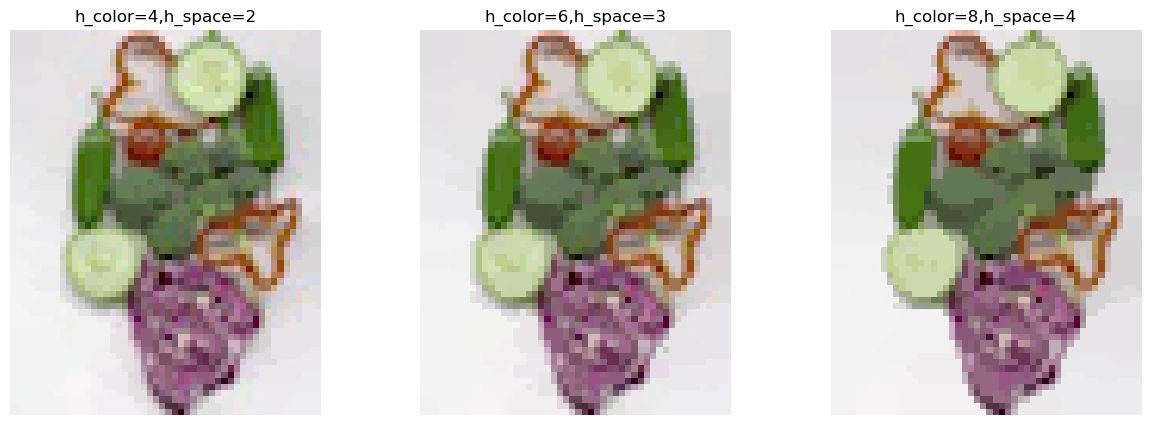

In [46]:
settings = [(4,2),(6,3),(8,4)]
fig, axes = plt.subplots(1,3,figsize=(15,5))
for ax, (hc, hs) in zip(axes, settings):
    h5 = [hc,hc,hc, hs,hs]
    m5, lab5 = mean_shift(features, h5, merge_tol=4.0, kernel='epanechnikov')
    seg_lab = m5[lab5,:3].reshape(H,W,3)
    seg_rgb = lab2rgb(seg_lab)
    ax.imshow(seg_rgb); ax.set_title(f"h_color={hc},h_space={hs}"); ax.axis('off')
plt.show()

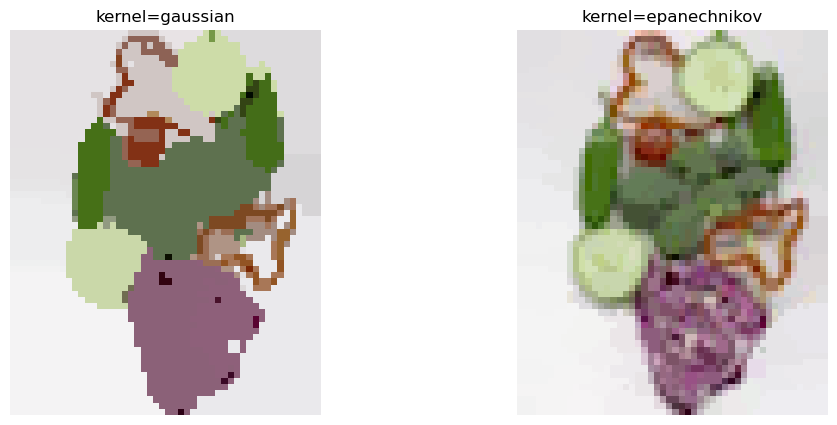

In [47]:

# %%
fig, axes = plt.subplots(1,2,figsize=(12,5))
for ax,kern in zip(axes,['gaussian','epanechnikov']):
    m5, lab5 = mean_shift(features, [6]*3+[3]*2, merge_tol=4, kernel=kern)
    seg_rgb = lab2rgb(m5[lab5,:3].reshape(H,W,3))
    ax.imshow(seg_rgb); ax.set_title(f"kernel={kern}"); ax.axis('off')
plt.show()


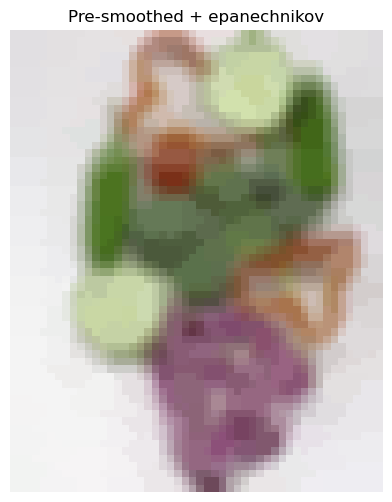

In [48]:

# %%
lab_blur = np.stack([gaussian(img_lab[:,:,i], sigma=1) for i in range(3)], axis=2)
feat_blur = np.column_stack([lab_blur.reshape(-1,3), x.ravel(), y.ravel()])
m_bl, lab_bl = mean_shift(feat_blur, [4]*3+[2]*2, merge_tol=4, kernel='epanechnikov')
seg_rgb_bl = lab2rgb(m_bl[lab_bl,:3].reshape(H,W,3))

plt.figure(figsize=(6,6))
plt.imshow(seg_rgb_bl); plt.title("Pre-smoothed + epanechnikov"); plt.axis('off')
plt.show()


# Part 2:

In Part 2 we apply mean-shift clustering to image segmentation in the 5-D Lab+position feature space. Below is the theoretical foundation:

---

## 1. Feature Construction

Each image pixel at spatial coordinates $(x,y)$ has an RGB color.  We convert to **Lab** space:

- $L$ (lightness),  
- $a$ (green–red),  
- $b$ (blue–yellow).

Then each pixel becomes a point  
$$
\mathbf{v} = [\,L,\,a,\,b,\,x,\,y\,]\in\mathbb{R}^5.
$$

---

## 2. Kernel Density in 5-D

We estimate the density 
$$
\hat f(\mathbf{v})
= \frac{1}{n\,\prod_d h_d}
\sum_{i=1}^n
K\!\Bigl(\sum_{d=1}^5 \frac{(v_d - v_{i,d})^2}{h_d^2}\Bigr),
$$
where  
- $K(t)$ is a kernel (Gaussian or Epanechnikov),  
- $h=(h_L,h_a,h_b,h_x,h_y)$ is a **bandwidth vector** scaling each Lab or spatial dimension.

---

## 3. Mean-Shift Update

The general mean-shift step in $\mathbb R^5$ is  
$$
\mathbf{v}_{\rm new}
=
\frac{\sum_{i=1}^n \mathbf{v}_i\;g\!\bigl(\sum_d((v_d - v_{i,d})/h_d)^2\bigr)}
     {\sum_{i=1}^n       g\!\bigl(\sum_d((v_d - v_{i,d})/h_d)^2\bigr)},
$$
where $g(t) = -K'(t)$.  Repeatedly applying this moves each pixel’s feature vector “uphill” in the density to a local **mode**.

---

## 4. Clustering & Segmentation

1. **Run** mean-shift on every pixel’s 5-D vector until convergence $\|\mathbf{v}_{\rm new}-\mathbf{v}\|<\text{tol}$.  
2. **Merge** all final modes whose Euclidean (scaled) distance  
   $$
   \sqrt{\sum_d\bigl((\mu_{i,d}-\mu_{j,d})/h_d\bigr)^2}
   <\varepsilon
   $$
   into single cluster centers.  
3. **Label** each pixel by its converged mode index.  
4. **Reconstruct** the segmented image by coloring each pixel with its cluster’s Lab color (then convert back to RGB via `lab2rgb`).

---

## 5. Choosing & Tuning Parameters

- **$h_L,h_a,h_b$ (color bandwidths)**:  
  - Small values separate subtle color differences.  
  - Large values merge similar hues into broader regions.

- **$h_x,h_y$ (spatial bandwidths)**:  
  - Small values restrict clustering to local neighborhoods (fine detail).  
  - Large values allow distant-but-similar pixels to join (over-smoothing).

- **Merge tolerance $\varepsilon$**:  
  - Smaller $\varepsilon$ preserves more distinct modes.  
  - Larger $\varepsilon$ fuses nearby modes into fewer segments.

- **Kernel choice**:  
  - **Gaussian** ($K(t)=e^{-t/2}$) gives smooth long-tailed weights.  
  - **Epanechnikov** ($K(t)=\max(1-t,0)$) hard-limits influence to within radius 1.

---

## 6. Optional Pre-processing

A light **Gaussian blur** on each Lab channel (e.g.\ $\sigma=1$) can remove sensor noise and tiny color speckles, yielding cleaner segmentation without spurious small clusters.

